## About

For protocols deciding which oracle to use, **reliability and robustness** are imperative. To showcase our reliability and robustness we decided to create a public track record of our performance starting with the very first price update. Empiric’s smart contracts emit an event every time a source sends new data on-chain which makes us the **only oracle on StarkNet with an auditable and transparent historical record today**.

Since going live as the **first oracle** on StarkNet, Empiric’s contracts have **emitted over 3.5M events, showcasing our near perfect accuracy and reliability over that time**. When controlling for StarkNet outages (during which no blocks get produced and everything on the network stops) we achieve 100% reliability and accuracy.

## This Document

Below is a new analysis of our performance the last 5+ weeks. This is not based on some internal record-keeping, but all **based on data publicly available on the blockchain** (see this script if you'd like to run yourself: https://github.com/Astraly-Labs/Empiric/blob/master/analytics/crawl_events.py).

We go through overall performance, identify anomalies and provide context on the background for each of those (StarkNet being down or breaking its own API/SDK).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("empiric-events.csv")
df = df.drop(columns="Unnamed: 0")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df[df["timestamp"] >= 1657092180] # This is when we upgraded from our previous oracle contract to this one

In [4]:
eth_data = df[df["key"] == "eth/usd"]
eth_data.loc[:, ["transaction_hash",]] = eth_data["transaction_hash"].apply(lambda x: hex(int(x)))

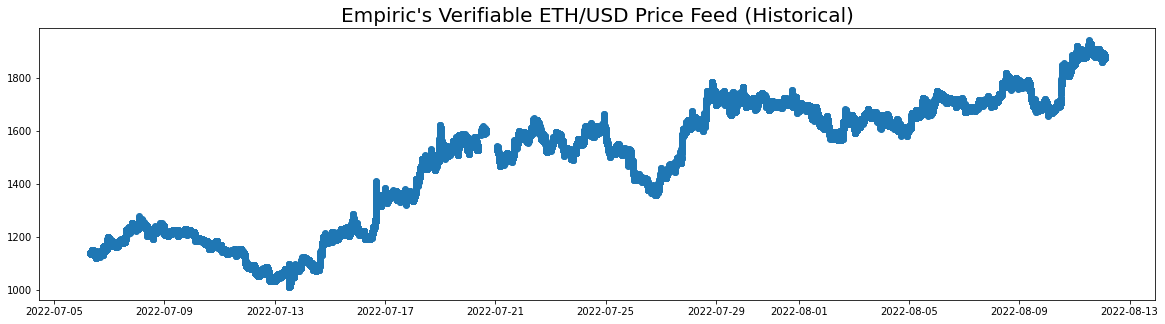

In [5]:
plt.figure(figsize=(20, 5))
plt.scatter(eth_data["datetime"], eth_data["value"])
plt.title("Empiric's Verifiable ETH/USD Price Feed (Historical)", fontsize=20)
plt.show()

In [6]:
eth_data = eth_data.sort_values("datetime")
eth_data["previous_datetime"] = eth_data.shift(1)["datetime"]
eth_data["time_diff"] = eth_data["datetime"] - eth_data["previous_datetime"]
eth_data["seconds_diff"] = eth_data["time_diff"].apply(lambda x: x.seconds)

## Frequency

The majority of **updates happens 3 seconds** after the last update. 75% of updates are at most 8 seconds apart.

There is no fixed time between updates because **Empiric is an entirely on-chain oracle** (making it verifiable, transparent and much more robust). The fact that many different data publishers provide data to Empiric's smart contracts makes the entire system much more resilient. As we can see, the absolute worst 1% of updates still take less than 2 minutes between updates.

In [7]:
eth_data["seconds_diff"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    264665.000000
mean         12.010156
std          77.001430
min           0.000000
25%           0.000000
50%           3.000000
75%           8.000000
90%          38.000000
95%          68.000000
99%         117.000000
max       34336.000000
Name: seconds_diff, dtype: float64

## Reliability

Empiric is extremely reliable. When controlling for StarkNet’s sequencer not processing transactions (in which case block production is of course halted and everything on StarkNet stops) we achieve 100% uptime and overall robustness. 

Let's investigate every single case where data updating took longer than expected time, filtering based on the time (in seconds) between updates:

In [8]:
eth_data[eth_data["seconds_diff"] > 1200]

,key,value,source,publisher,timestamp,transaction_hash,datetime,previous_datetime,time_diff,seconds_diff
1022156,eth/usd,1347.640,coinbase,equilibrium,1658065980,0x31bd64db4223626af06bb33f8457e1e81d895b94b246...,2022-07-17 13:53:00,2022-07-17 13:15:39,0 days 00:37:21,2241.0
1025638,eth/usd,1350.670,coinbase,pontis,1658073300,0x3b2ae9b2e3229aeb2b6f01da26b27af796cb58063c6a...,2022-07-17 15:55:00,2022-07-17 14:37:38,0 days 01:17:22,4642.0
1335188,eth/usd,1598.250,coingecko,empiric,1658315847,0x436776591febfb4a7048a5e2bc87fab7c2d6fcb0fc57...,2022-07-20 11:17:27,2022-07-20 09:02:42,0 days 02:14:45,8085.0
1342557,eth/usd,1537.690,coinbase,pontis,1658367900,0x25e345b2da76c33b340876ec61bb4d08a7ff183b0617...,2022-07-21 01:45:00,2022-07-20 16:12:44,0 days 09:32:16,34336.0
1496708,eth/usd,1536.610,coinbase,pontis,1658741040,0x1aabf1adeb11e98214e6f7cfaf79bb12a3afef8efe4d...,2022-07-25 09:24:00,2022-07-25 08:57:36,0 days 00:26:24,1584.0
1499606,eth/usd,1509.935,coinbase,pontis,1658759400,0x623520fb4ea20dca8314db4342e73d41018635b72c07...,2022-07-25 14:30:00,2022-07-25 11:17:37,0 days 03:12:23,11543.0


### Context on Reliability

**Timestamp 1658065980**: StarkNet block production was interrupted. See transaction hash that confirms transaction failed because it was processed more than an hour after being sent: 

https://alpha4.starknet.io/feeder_gateway/get_transaction_receipt?transactionHash=0x31bd64db4223626af06bb33f8457e1e81d895b94b246614e1ffc6e4f4766fdf

**Timestamp 1658073300**: StarkNet block production ceased. See blocks 270232

(https://goerli.voyager.online/block/0x4ab8df360db263c38952a70eb982de55ce6ebcbfc17fcb74da9e7fe1adad93f)

and 270233

(https://goerli.voyager.online/block/0x69192af2804f10281fb32df5d403bb6e74486f0c6f3972a9baa88592e283d1c)

**Timestamp 1658315847**: StarkNet upgraded to Cairo 0.9.1, breaking both the starknet.py and starknet.js SDKs. Our alerts picked up on it and we patched manually. We have agreed implemented better processes for breaking change releases with StarkWare and will deploy on their integration network in order to have earlier notice next time. On mainnet this will never happen because StarkWare releases changes on testnet a week in advance of mainnet.

**Timestamp 1658367900**: StarkNet block production ceased. See blocks 273104

(https://goerli.voyager.online/block/0x163f580b43d2b6059b26d6bf75739b30f33f43e19721baa605805daed131ff0)

and 273103

(https://goerli.voyager.online/block/0x1187a1ff3f96f9188a0d3f440131fc6cb6803e05966dae2f4bc82e65af2ed71)

**Timestamp 1658741040**: StarkNet block production was interrupted. See transaction hash that confirms transaction failed because it was processed more than an hour after being sent: 

https://alpha4.starknet.io/feeder_gateway/get_transaction_receipt?transactionHash=0x1aabf1adeb11e98214e6f7cfaf79bb12a3afef8efe4db553f12260f22b0fe01

**Timestamp 1658759400**: StarkNet block production ceased. See blocks 277167

(https://goerli.voyager.online/block/0x2e9a40f4e77a9a24a882f371af80a21f1a3b027080aa35ae8cbfd5d9124b297)

and 277168

(https://goerli.voyager.online/block/0x41f1ff9dfd1511c64099c7206301d35b9c247ed2561a350223e126279eda42c)